# Download complexome from Complex Portal database and analyze basic statistics.

## The complexome comprises all annotated protein complexes within the cell, directly linking to biological function.

In [1]:
import os, csv, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from datetime import date
today = date.today()

#### Define parameters and file names. Edit the organism taxonomic identifier, if necessary. E.g., '9606' is Homo Sapiens.

In [2]:
organism_taxon_id = "9606" # Taxonomic ID of the organism of interest.
ComplexomeSavedFile = organism_taxon_id + ".tsv" # Downloaded complexome file in ComplexTAB format.
ComplexomeFile = organism_taxon_id + "Complexome_" + str(today) + ".tsv" # Rename complexome file with a date stamp for future reference.
ppComplexesObject = organism_taxon_id + "Complexome_" + str(today) + ".pickle" # Create a pickle object of the complexome and save with a date stamp.
ppComplexNamesObject = organism_taxon_id + "ComplexNames_" + str(today) + ".pickle" # Save the complex names.
ppComplexGOTermsObject = organism_taxon_id + "ComplexGOTerms_" + str(today) + ".pickle" # Save the associated GO terms for each complex.
isHeader = True # The complexome file has a header line.

#### Download Complexome file for the specified organism from Complex Portal.

In [3]:
urlretrieve("http://ftp.ebi.ac.uk/pub/databases/intact/complex/current/complextab/" + ComplexomeSavedFile, ComplexomeFile)

('9606Complexome_2024-05-14.tsv', <http.client.HTTPMessage at 0x10b630800>)

#### Calculate statistics on the downloaded complexome file (number of unique proteins, number of complexes, etc.).

In [4]:
def addComplexParticipants(participantsList,members):
    for participant in participantsList.split('|'):
        participantId = participant.split("(")[0]
        if "[" in participantId:
            # This is in the case of molecule sets (paralogs that cannot be distinguished in this context).
            participant_ids = str(participantId).replace('[', '').replace(']', '').split(',')
            for paralog in participant_ids:
                if paralog not in members:
                    members.append(paralog)
        else:
            if participantId not in members:
                members.append(participantId)
                        
    return members

In [5]:
def ComplexSubunitNumbersDistribution(complexesDict):
    numSubunitsPerComplex = {}
    for key, value in complexesDict.items():
        if len(value) not in numSubunitsPerComplex:
            numSubunitsPerComplex[len(value)] = [key]
        else:
            numSubunitsPerComplex[len(value)].append(key)

    numSubunitsPerComplexDist = {key: len(value) for key,value in numSubunitsPerComplex.items()}

    return numSubunitsPerComplexDist

In [6]:
def write_to_csv(moleculeList,outputFileName):
    with open(outputFileName, 'w') as outputFile:
        for molecule in moleculeList:
            outputFile.write(molecule + '\n')

In [7]:
# Open and parse the Complex Portal data file and collect the per complex list of participants.
Complexes = {}
ComplexNames = {}
ComplexesGOTerms = {}
with open(ComplexomeFile) as fd:
    rd = csv.reader(fd, delimiter="\t")
    for row in rd:
        if isHeader:
            isHeader = False
            continue

        # Each row corresponds to a specific, annotated complex.
        complexID = row[0]
        complexName = row[1]
        complexTaxonID = row[3]
        complexParticipants = row[4]
        complexExtendedParticipants = row[-1]
        complexAnnotatedGOTerms = row[7]

        # Make sure that the organism taxon id is matching.
        if complexTaxonID != organism_taxon_id:
            print(row)
            print("Organism taxon id does not match with the expected organism!")
            sys.exit()

        # Extract information about the participants of the complex. Participants can include proteins (UniProtKB), chemical entities (ChEBI), RNA (RNAcentral) and complexes (Complex Portal).
        complexMembers = []
        complexMembers = addComplexParticipants(complexParticipants,complexMembers)
        
        # Check if one or more participants are themselves complexes. In that case, the expanded list of protein members are contained in the Expanded participant list (last) column.
        if "CPX-" in complexParticipants:
            complexMembers = addComplexParticipants(complexExtendedParticipants,complexMembers)

        # Add information about this complex and its participant molecules into the global dictionary of complexes.
        if complexID not in Complexes:
            Complexes[complexID] = complexMembers
            ComplexNames[complexID] = complexName
        else:
            print("Complex ID already exists:",complexID)
            print("Stopping for checks!!")
            sys.exit()

        # Extract information about the annotated GO terms of the complex.
        complexGOTerms = complexAnnotatedGOTerms.split('|')

        # Add information about this complex and its associated GO terms into the global dictionary of GO terms.
        if complexID not in ComplexesGOTerms:
            ComplexesGOTerms[complexID] = complexGOTerms
        else:
            print("Complex ID already exists:",complexID)
            print("Stopping for checks!!")
            sys.exit()

fd.close()

In [8]:
# Save the complexes dictionary as a pickle object.
with open(ppComplexesObject, 'wb') as output:
    pickle.dump(Complexes, output, pickle.HIGHEST_PROTOCOL)

with open(ppComplexNamesObject, 'wb') as output:
    pickle.dump(ComplexNames, output, pickle.HIGHEST_PROTOCOL)

with open(ppComplexGOTermsObject, 'wb') as output:
    pickle.dump(ComplexesGOTerms, output, pickle.HIGHEST_PROTOCOL)

print("Total number of annotated complexes:",len(Complexes))
print("Total number of complex names:",len(ComplexNames))
print("Total number of complexes with associated GO terms:",len(ComplexesGOTerms))

Total number of annotated complexes: 2050
Total number of complex names: 2050
Total number of complexes with associated GO terms: 2050


In [9]:
# Iterate over the list of complexes and store the unique proteins, metabolites and RNA molecules contained in that complexome.
uniqueProteins = []
uniqueMetabolites = []
for complex in Complexes:
    for subunit in Complexes[complex]:
        if "CPX-" in subunit:
            continue
        elif "URS" in subunit:
            continue
        elif "CHEBI:" in subunit:
            if subunit not in uniqueMetabolites:
                uniqueMetabolites.append(subunit)
        else:
            if subunit not in uniqueProteins:
                uniqueProteins.append(subunit)

print("Total number of unique proteins:",len(uniqueProteins))
print("Total number of unique metabolites:",len(uniqueMetabolites))

Total number of unique proteins: 3239
Total number of unique metabolites: 50


In [10]:
write_to_csv(uniqueMetabolites, organism_taxon_id + "_metabolites_" + str(today) + ".csv")
write_to_csv(uniqueProteins,organism_taxon_id + "_proteins_" + str(today) + ".csv")

#### Plot summary statistics.

In [11]:
numAllSubunitsPerComplexDist = ComplexSubunitNumbersDistribution(Complexes)

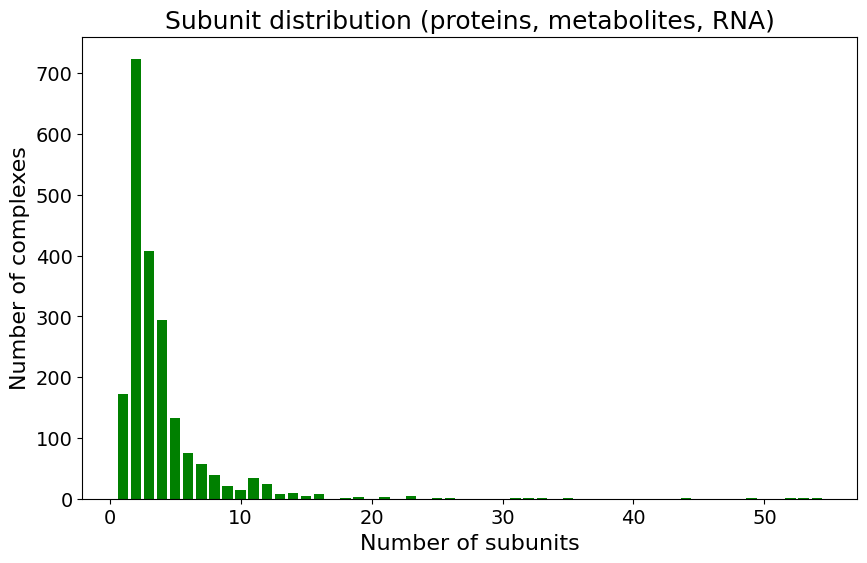

In [12]:
plt.figure(figsize=(10,6))
plt.bar(list(numAllSubunitsPerComplexDist.keys()), numAllSubunitsPerComplexDist.values(), color='g')
plt.xlabel("Number of subunits", fontsize=16)
plt.ylabel("Number of complexes", fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Subunit distribution (proteins, metabolites, RNA)", fontsize=18)
plt.show()

In [13]:
# Iterate over the list of complexes and store the protein subunits only per complex.
proteinSubunitsPerComplex = {}
for complex in Complexes:
    proteinSubunits = []
    for subunit in Complexes[complex]:
        if "CPX-" in subunit:
            continue
        elif "URS" in subunit:
            continue
        elif "CHEBI:" in subunit:
            continue
        else:
            if subunit not in proteinSubunits:
                proteinSubunits.append(subunit)

    proteinSubunitsPerComplex[complex] = proteinSubunits

In [14]:
numProteinSubunitsPerComplexDist = ComplexSubunitNumbersDistribution(proteinSubunitsPerComplex)

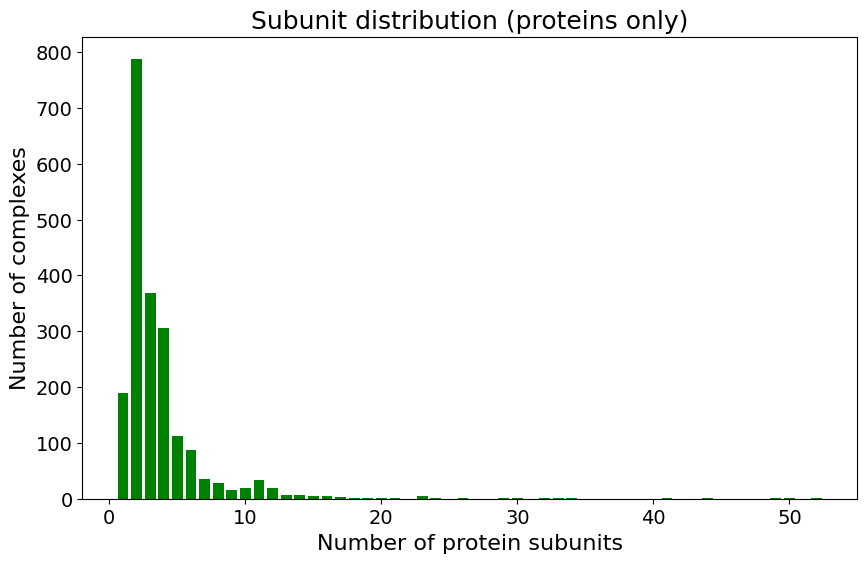

In [15]:
plt.figure(figsize=(10,6))
plt.bar(list(numProteinSubunitsPerComplexDist.keys()), numProteinSubunitsPerComplexDist.values(), color='g')
plt.xlabel("Number of protein subunits", fontsize=16)
plt.ylabel("Number of complexes", fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Subunit distribution (proteins only)", fontsize=18)
plt.show()

In [16]:
# Compute the distibution of shared protein subunits among the different complexes.
proteinsInNumComplexes = {}
for protein in uniqueProteins:
    for complex in proteinSubunitsPerComplex:
        if protein in proteinSubunitsPerComplex[complex]:
            if protein not in proteinsInNumComplexes:
                proteinsInNumComplexes[protein] = 1
            else:
                proteinsInNumComplexes[protein] += 1

In [17]:
sharedSubunitsPerComplex = {}
for key, value in proteinsInNumComplexes.items():
    # Useful to collate all values >10 into the last bar on the plot (see below).
    if value > 10:
        value = 10
    if value not in sharedSubunitsPerComplex:
        sharedSubunitsPerComplex[value] = 1
    else:
        sharedSubunitsPerComplex[value] += 1

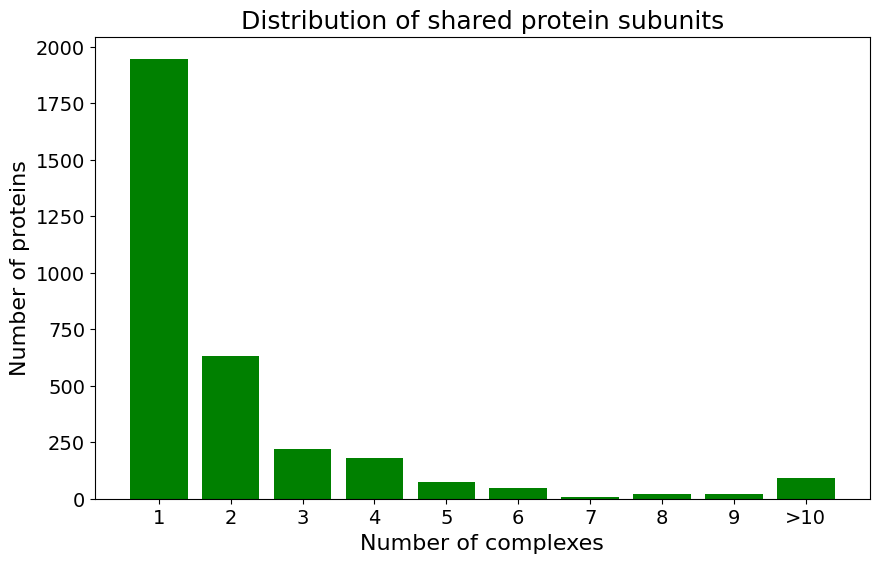

In [18]:
plt.figure(figsize=(10,6))
plt.bar(list(sharedSubunitsPerComplex.keys()), sharedSubunitsPerComplex.values(), color='g')
plt.xlabel("Number of complexes", fontsize=16)
plt.ylabel("Number of proteins", fontsize=16)
plt.xticks(np.arange(1,11), ['1','2','3','4','5','6','7','8','9','>10'], size=14)
plt.yticks(size=14)
plt.title("Distribution of shared protein subunits", fontsize=18)
plt.show()